In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import matplotlib.pyplot as plt
import json

%matplotlib inline

import sys
import os


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
sys.path.append('../')

In [4]:
import phononet as pn

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:01<00:00, 194.55it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y)[...,np.newaxis].astype(np.int8)

In [8]:
def gen(X,y,augment):
    n=len(X_train)
    l=list(range(12))

    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])

    while True:
        idx=np.random.randint(n)
        if augment:
            i=np.random.randint(12)
            yield X_train[idx].take(ls[i],axis=0),y_train[idx]
        else:
            yield X_train[idx],y_train[idx]




In [89]:
BATCH_SIZE=32
AUGMENT=False
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).shuffle(1000).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [90]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, size, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(**kwargs) # handles base args (e.g., dtype)
        self.size=size
        self.total_cm = self.add_weight("total", shape=(size,size), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.size)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    


In [91]:
class MySequential(keras.Sequential):
    
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    
    def train_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)  # Forward pass
                # Compute the loss value.
                # The loss function is configured in `compile()`.
                loss = self.compiled_loss(
                    y,
                    y_pred,
                    regularization_losses=self.losses,
                )

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
        
        
    def test_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            y_pred = self(x, training=False)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
            


In [92]:
from tensorflow.keras.models import Sequential

In [93]:
class PeriodicPaddingConv2D(keras.layers.Conv2D):
    
    # Note this ONLY works now for filter size 3 and stride of 1
    
    def __init__(self,*args,**kwargs):
        padding_val=kwargs.pop('padding',None)
        if padding_val=='same':
            print('For PeriodPaddingConv2D padding must be valid so setting it to valid.')
            
            # TODO: padding is the same in all directions and we thus loose length in the time direction
            # Should not be a big deal but we can change this by padding zeros explicitely.
            kwargs['padding']='valid'
        super().__init__(*args,**kwargs)
            
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        x=tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))
        return super().call(x)
    



In [94]:
from tensorflow.keras.layers import Conv2D

In [95]:
ConvLayer=Conv2D

In [164]:
keras.layers.Dense(20,kernel_initializer='lecun_normal')

In [177]:
dropout_prob=0.3
PADDING_TYPE='same'

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    ConvLayer(64,(3,3),name='conv1',padding=PADDING_TYPE,kernel_initializer='lecun_normal'),
    keras.layers.LeakyReLU(name='relu1'),
    keras.layers.BatchNormalization(name='norm1',axis=[3]), # batch normalization on everything but last dimension
    keras.layers.MaxPool2D((1,2),name='pool1'),
    keras.layers.Dropout(dropout_prob,name='drop1'),
    #
    ConvLayer(128,(3,3),name='conv2',padding=PADDING_TYPE,kernel_initializer='lecun_normal'),
    keras.layers.LeakyReLU(name='relu2'),
    keras.layers.BatchNormalization(name='norm2',axis=[3]),
    keras.layers.MaxPool2D((1,3),name='pool2'),
    keras.layers.Dropout(dropout_prob,name='drop2'),
    #
    ConvLayer(150,(3,3),name='conv3',padding=PADDING_TYPE,kernel_initializer='lecun_normal'),
    keras.layers.LeakyReLU(name='relu3'),
    keras.layers.BatchNormalization(name='norm3',axis=[3]),
    keras.layers.MaxPool2D((1,2),name='pool3'),
    keras.layers.Dropout(dropout_prob,name='drop3'),
    #
    ConvLayer(200,(3,3),name='conv4',padding=PADDING_TYPE,kernel_initializer='lecun_normal'),
    keras.layers.LeakyReLU(name='relu4'),
    keras.layers.BatchNormalization(name='norm4',axis=[3]),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer='lecun_normal')

])

model.summary()

Model: "my_sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
conv1 (Conv2D)               (None, 12, 1500, 64)      640       
_________________________________________________________________
relu1 (LeakyReLU)            (None, 12, 1500, 64)      0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 12, 1500, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 12, 750, 64)       0         
_________________________________________________________________
drop1 (Dropout)              (None, 12, 750, 64)  

In [178]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [179]:
history=model.fit(train_data,validation_data=val_data,epochs=10,steps_per_epoch=len(X_train)//BATCH_SIZE)

Epoch 1/10
72/72 [==============================] - 15s 210ms/step - loss: 3.3042 - accuracy: 0.0924 - F1_0: 0.0000e+00 - F1_1: 0.0469 - F1_2: 0.0000e+00 - F1_3: 0.0087 - F1_4: 0.0238 - F1_5: 0.0338 - F1_6: 0.0000e+00 - F1_7: 0.0597 - F1_8: 0.0970 - F1_9: 0.0242 - F1_10: 0.0689 - F1_11: 0.0000e+00 - F1_12: 0.0559 - F1_13: 0.0040 - F1_14: 0.0745 - F1_15: 0.0531 - F1_16: 0.0387 - F1_17: 0.1033 - F1_18: 0.1044 - F1_19: 0.1486 - F1_20: 0.0356 - F1_21: 0.0400 - F1_22: 0.0411 - F1_23: 0.1184 - F1_24: 0.0000e+00 - F1_25: 0.1056 - F1_26: 0.2075 - F1_27: 0.0000e+00 - F1_28: 0.0634 - F1_29: 0.0453 - val_loss: 4.7418 - val_accuracy: 0.0558 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0000e+00 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 

72/72 [==============================] - 15s 203ms/step - loss: 1.9811 - accuracy: 0.4497 - F1_0: 0.3102 - F1_1: 0.0630 - F1_2: 0.2225 - F1_3: 0.2647 - F1_4: 0.5676 - F1_5: 0.4224 - F1_6: 0.1044 - F1_7: 0.4415 - F1_8: 0.5503 - F1_9: 0.4353 - F1_10: 0.4164 - F1_11: 0.1609 - F1_12: 0.5055 - F1_13: 0.0915 - F1_14: 0.6639 - F1_15: 0.5366 - F1_16: 0.3681 - F1_17: 0.2996 - F1_18: 0.4079 - F1_19: 0.5084 - F1_20: 0.5454 - F1_21: 0.3738 - F1_22: 0.5626 - F1_23: 0.4415 - F1_24: 0.2199 - F1_25: 0.4067 - F1_26: 0.6291 - F1_27: 0.0000e+00 - F1_28: 0.5466 - F1_29: 0.2549 - val_loss: 3.7509 - val_accuracy: 0.1462 - val_F1_0: 0.1061 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0177 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0800 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0513 - val_F1_9: 0.0632 - val_F1_10: 0.4673 - val_F1_11: 0.0000e+00 - val_F1_12: 0.1026 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.1121 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0000e+00 - va

In [180]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'tmp.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [181]:
#model.save_weights('phase_1_weights_100_epochs')

In [182]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [183]:
training_history_file

'training_history/tmp.json'

In [184]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [185]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [186]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

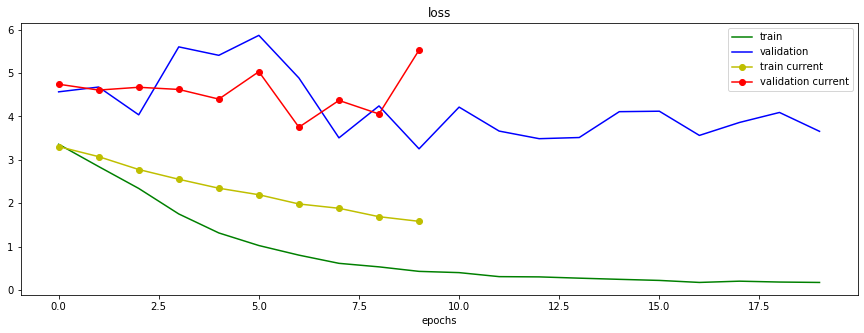

In [187]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
#plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
#plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()

Text(0.5, 1.0, 'accuracy')

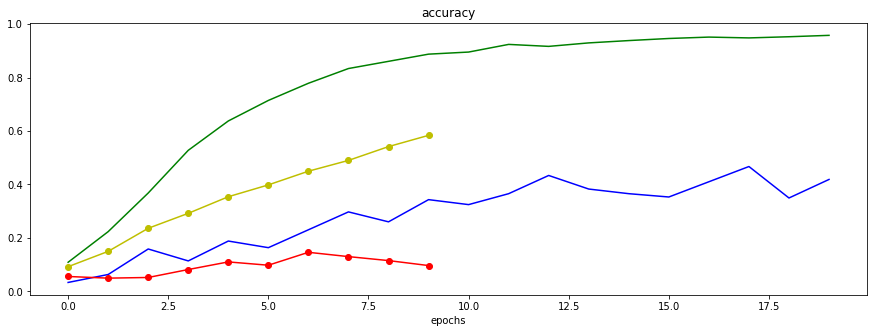

In [188]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
#plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
#plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.xlabel('epochs')
plt.title('accuracy')

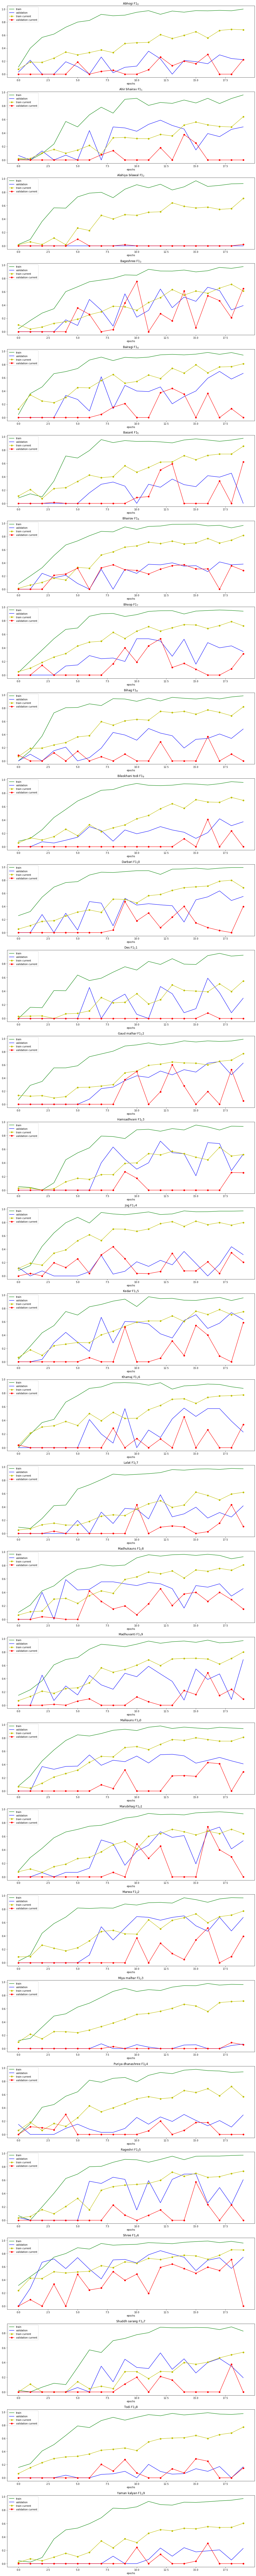

In [145]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    #plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    #plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
plt.tight_layout()

# work related to periodic padding

Based on https://stackoverflow.com/questions/39088489/tensorflow-periodic-padding

In [301]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([4, 3]), TensorShape([6, 4]))

In [302]:
result=tf.matmul(pre,a)
result

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [308]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])[tf.newaxis,...,tf.newaxis]
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([1, 4, 3, 1]), TensorShape([6, 4]))

In [310]:
tf.transpose(tf.tensordot(pre,a,axes=[1,1]),(1,0,2,3))[0,:,:,0]

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [316]:
pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0))

In [322]:
class PeriodicPadding(keras.layers.Layer):
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        return tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))

In [323]:
pp=PeriodicPadding()


In [328]:
next(iter(train_data))[0][...,tf.newaxis]

<tf.Tensor: shape=(32, 12, 1500, 1), dtype=float32, numpy=
array([[[[0.35395238],
         [0.62483937],
         [0.2514335 ],
         ...,
         [0.03919563],
         [0.02934529],
         [0.04388006]],

        [[0.8546381 ],
         [1.        ],
         [1.        ],
         ...,
         [0.04332115],
         [0.05731897],
         [0.0764455 ]],

        [[1.        ],
         [0.41365883],
         [0.18235262],
         ...,
         [0.84097314],
         [1.        ],
         [1.        ]],

        ...,

        [[0.26271972],
         [0.18089055],
         [0.0787217 ],
         ...,
         [0.09863921],
         [0.1284486 ],
         [0.08776184]],

        [[0.09208088],
         [0.05293678],
         [0.01514117],
         ...,
         [0.11066498],
         [0.06546266],
         [0.09747966]],

        [[0.15809135],
         [0.20290934],
         [0.01715337],
         ...,
         [0.01311859],
         [0.00853989],
         [0.01680734]]],


 

In [329]:
pp(next(iter(train_data))[0][...,tf.newaxis])

<tf.Tensor: shape=(32, 14, 1500, 1), dtype=float32, numpy=
array([[[[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]],

        [[0.01490354],
         [0.0233238 ],
         [0.05875514],
         ...,
         [0.9334802 ],
         [0.6985323 ],
         [0.5537118 ]],

        ...,

        [[0.02656923],
         [0.02724202],
         [0.02169165],
         ...,
         [0.4590119 ],
         [0.10448112],
         [0.02082583]],

        [[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]]],


 

In [335]:
c=keras.layers.Conv2D(5,(3,3), padding='valid')

In [336]:
c(pp(next(iter(train_data))[0][...,tf.newaxis]))

<tf.Tensor: shape=(32, 12, 1498, 5), dtype=float32, numpy=
array([[[[-8.96642953e-02,  1.67192012e-01,  1.22336112e-01,
          -1.19068444e-01,  9.58066359e-02],
         [-3.46585698e-02,  7.98996314e-02,  4.03669477e-02,
          -4.02128436e-02,  3.63214836e-02],
         [-2.91647911e-02,  6.70691654e-02,  2.11968012e-02,
          -1.92416068e-02,  2.24674847e-02],
         ...,
         [-1.34937856e-02,  3.23149301e-02, -1.19507752e-01,
           4.22342382e-02, -1.86150316e-02],
         [-2.89242696e-02, -1.16442721e-02, -1.39085233e-01,
           3.14064734e-02, -4.74732667e-02],
         [ 1.53264939e-03, -1.27264662e-02, -1.15292117e-01,
          -2.16421927e-03, -1.15130302e-02]],

        [[-3.63824517e-02, -7.21778767e-03, -6.31002188e-02,
           7.43871881e-03, -7.56851304e-03],
         [-3.52892838e-03,  1.77940354e-02, -3.32056433e-02,
           2.14235857e-03,  1.07655795e-02],
         [-2.26242933e-02,  1.72086544e-02, -5.05561940e-02,
           1.655

Should try the alternate method which is a bit memory heavy compare to the above



In [360]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9]])[tf.newaxis,...,tf.newaxis]
b = tf.tile(a, [1,3, 1,1])
result = b[:,2:7, :,:]

In [362]:
result[0,:,:,0]

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[7, 8, 9],
       [1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 3]], dtype=int32)>